[Control 2] Analysis of the results
--------

This notebook focuses on the analysis of the properties for the control setting.
In particular, when generating sentences from diferent models with different decoding algorithms:

- How do different properties of the model change?
- Do we obtain multimodal distributions?
- Does the 10-th or 90-th percentile analysis tells a different story than the average?

In [1]:
from typing import List

import pandas as pd
import numpy as np

import os

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette(sns.color_palette("colorblind"))

## Load Data

This version of the code is limited to processing a single sample (i.e., sampled with a single seed for the same decoding configuration). Bootstrap-like analysis are not being considered in this notebook

In [3]:
# -----------------------------------------------------------------
# Global constants setup: User should update these variables
# -----------------------------------------------------------------

MODEL = "EleutherAI__pythia-1.4b" 

DECODING_SETUP = [
    ("temperature", (0.1, 0.3, 0.5, 1.15, 1.5)),
    ("top_k", (2, 10, 40, 100)),
    ("top_p", (0.1, 0.3, 0.5, 0.7, 0.8, 0.9)),
]

RESULTS_DIR = "/extra/ucinlp1/cbelem/experiment-ro-prompts/generations-results/uncond-half-multinomial"
MULT_DATA = pd.read_csv(f"{RESULTS_DIR}/{MODEL}/raw_data.csv", index_col=0)

# MODIFY MULTINOMIAL TO FIT THE DATA format (must update after meeting)
multinomial = MULT_DATA.copy()
multinomial["decoding"] = "multinomial"

multinomial_renaming_cols = [
    'sequence_num_chars', 
    'sequence_num_sentences',
    'sequence_num_punct',
    'sequence_num_words', 
    'sequence_unique_words',
    'sequence_diversity',
    'sequence_toxicity',
    'sequence_severe_toxic',
    'sequence_obscene',
    'sequence_threat',
    'sequence_insult',
    'sequence_identity_hate',
]
multinomial = multinomial.rename({col: f"sampled_{col}" for col in multinomial_renaming_cols}, axis=1)
multinomial["sampled_continuation"] = multinomial["continuation"]
multinomial["sampled_sequence"] = multinomial["sequence"]

multinomial_drop_cols = [
    'prefix_num_chars',
    'prefix_num_sentences', 'prefix_num_punct', 'prefix_num_words',
    'prefix_unique_words', 'prefix_diversity', 'prefix_toxicity',
    'prefix_severe_toxic', 'prefix_obscene', 'prefix_threat',
    'prefix_insult', 'prefix_identity_hate'
]
multinomial = multinomial.drop(multinomial_drop_cols, axis=1)
for prop in ["toxicity", "num_punct", "diversity", "unique_words", "num_sentences"]:
        multinomial[f"delta_{prop}"] = multinomial[f"sampled_sequence_{prop}"] - MULT_DATA[f"prefix_{prop}"]

# -----------------------------------------------------------------

def get_filenames(base_dir: str, model: str, decoding_configs: List) -> List[str]:
    """Compute all filenames for a given model and decoding configs."""
    def parse_decoding_algo(dec):
        if isinstance(dec, str):
            return [dec]
        
        elif isinstance(dec, tuple) and len(dec) == 2:
            if dec[0] =="temperature":
                return [f"temperature_{d}" for d in dec[1]]
            if dec[0] =="top_p":
                return [f"top_p_{p}" for p in dec[1]]
            if dec[0] =="top_k":
                return [f"top_k_{k}" for k in dec[1]]
        else:
            raise ValueError(f"Decoding config unknown: {dec}")
            
    decodings = []
    filepaths = []
    
    for configs in decoding_configs:
        for config in parse_decoding_algo(configs):
            fp = f"{base_dir}/{model}/{config}.csv"
            
            if os.path.isfile(fp):
                decodings.append(config)
                filepaths.append(fp)
            else:
                print("FileNotFound:\n-->", fp)
                
    return decodings, filepaths


# --------------------------------------------------
# Read files
# --------------------------------------------------
decodings, filepaths = get_filenames(RESULTS_DIR, MODEL, DECODING_SETUP)
files = [pd.read_csv(fp, index_col=0) for fp in filepaths]

# ADD DELTA
for file in files:
    for prop in ["toxicity", "num_punct", "diversity", "unique_words", "num_sentences"]:
        file[f"delta_{prop}"] = file[f"sampled_sequence_{prop}"] - MULT_DATA[f"prefix_{prop}"]

# ADD MULTINOMIAL
#decodings =  ["multinomial"] + decodings
#files = [MULT_DATA] + files

# Discriminate between different decodings
all_files = {"temp": [], "top_p": [], "top_k": []}

for file, decoding in zip(files, decodings):
    file.insert(0, "decoding", decoding)
    
    if decoding == "multinomial":
        all_files["temp"].append(file)
        all_files["top_p"].append(file)
        all_files["top_k"].append(file)
    elif decoding.startswith("temperature"):
        all_files["temp"].append(file)
    elif decoding.startswith("top_k"):
        all_files["top_k"].append(file)
    elif decoding.startswith("top_p"):
        all_files["top_p"].append(file)
        
    file = file.drop(['sampled_seq_trans_log_probs', 'sampled_seq_entropy_log_probs', "sampled_sequence_log_prob"], axis=1)
    
    
decodings = ["multinomial"] + decodings
files = [multinomial] + files
# all_files: mapping decoding_algo --> dataframe
all_files = {dec: pd.concat(dec_files, axis=0) for dec, dec_files in all_files.items()}
# all_files concatenated
all_files_concat = pd.concat(files, axis=0)

## Properties distribution

In [5]:
DEFAULT_PALETTE = sns.color_palette("colorblind", n_colors=1)

# fixme - hard coded decoding groupings
TEMP_DECODINGS = ['temperature_0.1', 'temperature_0.3', 'temperature_0.5', 'temperature_1.15', 'temperature_1.5']
TOPK_DECODINGS = ['top_k_2', 'top_k_10', 'top_k_40', 'top_k_100']
TOPP_DECODINGS = ['top_p_0.1', 'top_p_0.3', 'top_p_0.5', 'top_p_0.7', 'top_p_0.8', 'top_p_0.9']

TEMP_PALETTE = sns.color_palette("Greens", n_colors=len(TEMP_DECODINGS))
TOPK_PALETTE = sns.color_palette("Greys", n_colors=len(TOPK_DECODINGS))
TOPP_PALETTE = sns.color_palette("Reds", n_colors=len(TOPP_DECODINGS))

DEFAULT_COLORS = {
    "temp": {c: TEMP_PALETTE[i] for i, c in enumerate(TEMP_DECODINGS)},
    "top_p": {c: TOPP_PALETTE[i] for i, c in enumerate(TOPP_DECODINGS)},
    "top_k": {c: TOPK_PALETTE[i] for i, c in enumerate(TOPK_DECODINGS)},
}
DEFAULT_COLORS["temp"]["multinomial"] = DEFAULT_PALETTE[0]
DEFAULT_COLORS["top_p"]["multinomial"] = DEFAULT_PALETTE[0]
DEFAULT_COLORS["top_k"]["multinomial"] = DEFAULT_PALETTE[0]

ALL_COLORS = {}
ALL_COLORS.update(**DEFAULT_COLORS["temp"])
ALL_COLORS.update(**DEFAULT_COLORS["top_p"])
ALL_COLORS.update(**DEFAULT_COLORS["top_k"])

In [6]:
def compute_avgs(data: pd.DataFrame, property1: str, colname: str) -> tuple:
    avgs = data[[colname, property1]].groupby(colname).mean()[property1]
    dec, dec_avg = zip(*avgs.items())
    # returns the name of the decoding algorithm and its
    # decoding_avg
    return dec, dec_avg


def plot_histograms(property1, figsize=(20, 6), **kwargs):
    fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=figsize)
    fig.suptitle(f"{property1} distribution")
    hist_kwargs = dict(hue="decoding", x=property1, element="step", alpha=0.3, stat="probability")
    hist_kwargs.update(**kwargs)
    for i, decode_alg in enumerate(("temp", "top_p", "top_k")):
        data, palette = all_files[decode_alg], DEFAULT_COLORS[decode_alg]

        axes[i].set_title(decode_alg)
        ax = sns.histplot(data, palette=palette, ax=axes[i], **hist_kwargs)
            
        dec_algs, dec_avgs = compute_avgs(data, property1, "decoding")
        for alg, avg in zip(dec_algs, dec_avgs):
            ax.axvline(avg, label=alg, color=palette[alg], ls="--")
            
    plt.tight_layout()

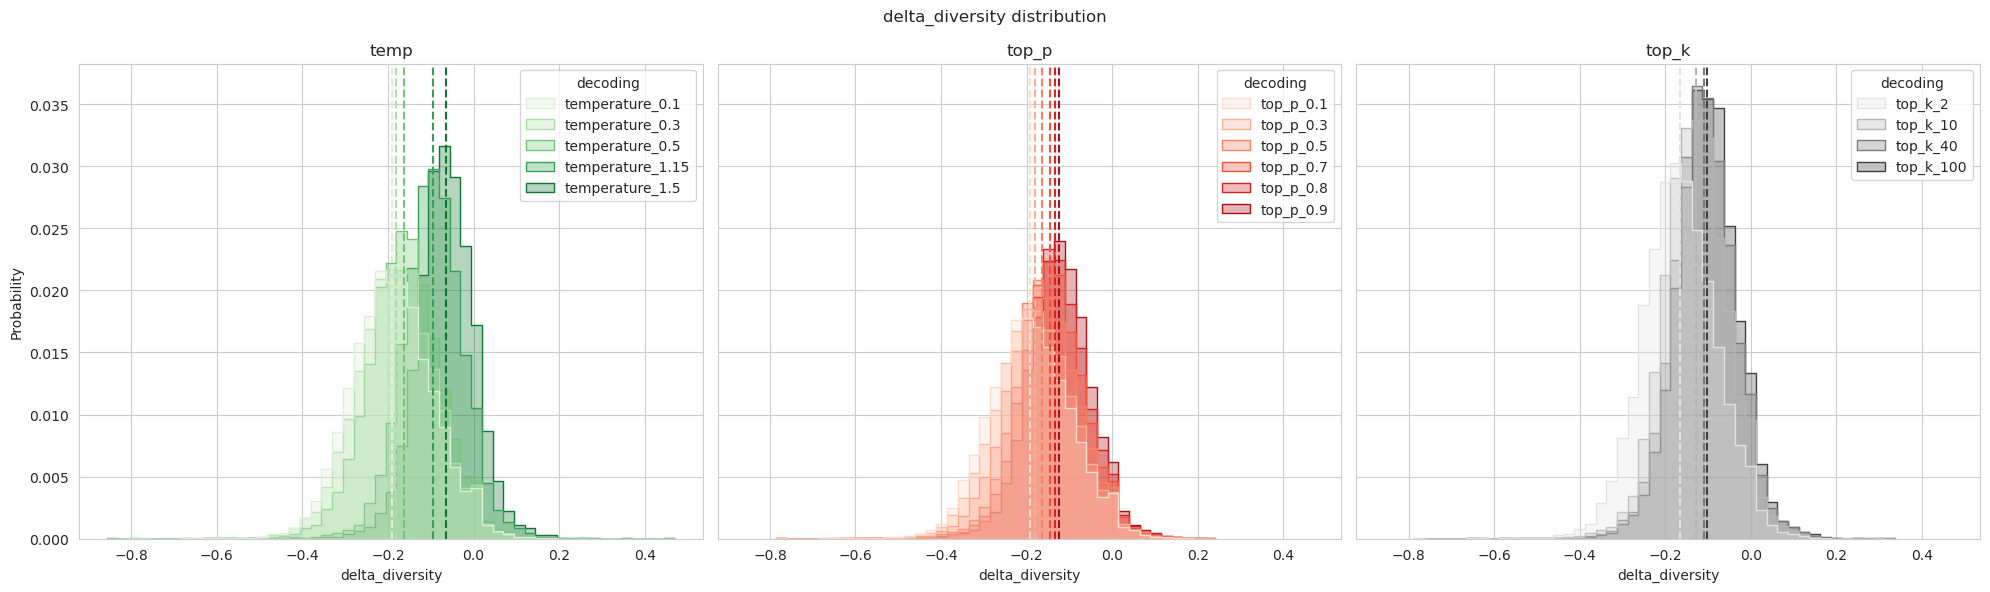

In [35]:
plot_histograms(property1="delta_diversity", binwidth=0.025)
plt.show()

In [41]:
plot_histograms(property1="sampled_sequence_toxicity", binwidth=0.02)
plt.show()
plot_histograms(property1="sampled_sequence_toxicity", binwidth=0.02)
plt.yscale("log")
plt.show()

Index(['sequence', 'prefix', 'continuation', 'sequence_num_tokens',
       'prefix_num_tokens', 'continuation_num_tokens', 'sampling_kwargs',
       'original_filepath', 'prefix_kwargs', 'sampled_sequence_num_chars',
       'sampled_sequence_num_sentences', 'sampled_sequence_num_punct',
       'sampled_sequence_num_words', 'sampled_sequence_unique_words',
       'sampled_sequence_diversity', 'sampled_sequence_toxicity',
       'sampled_sequence_severe_toxic', 'sampled_sequence_obscene',
       'sampled_sequence_threat', 'sampled_sequence_insult',
       'sampled_sequence_identity_hate', 'decoding', 'sampled_continuation',
       'sampled_sequence', 'delta_toxicity', 'delta_num_punct',
       'delta_diversity', 'delta_unique_words', 'delta_num_sentences'],
      dtype='object')

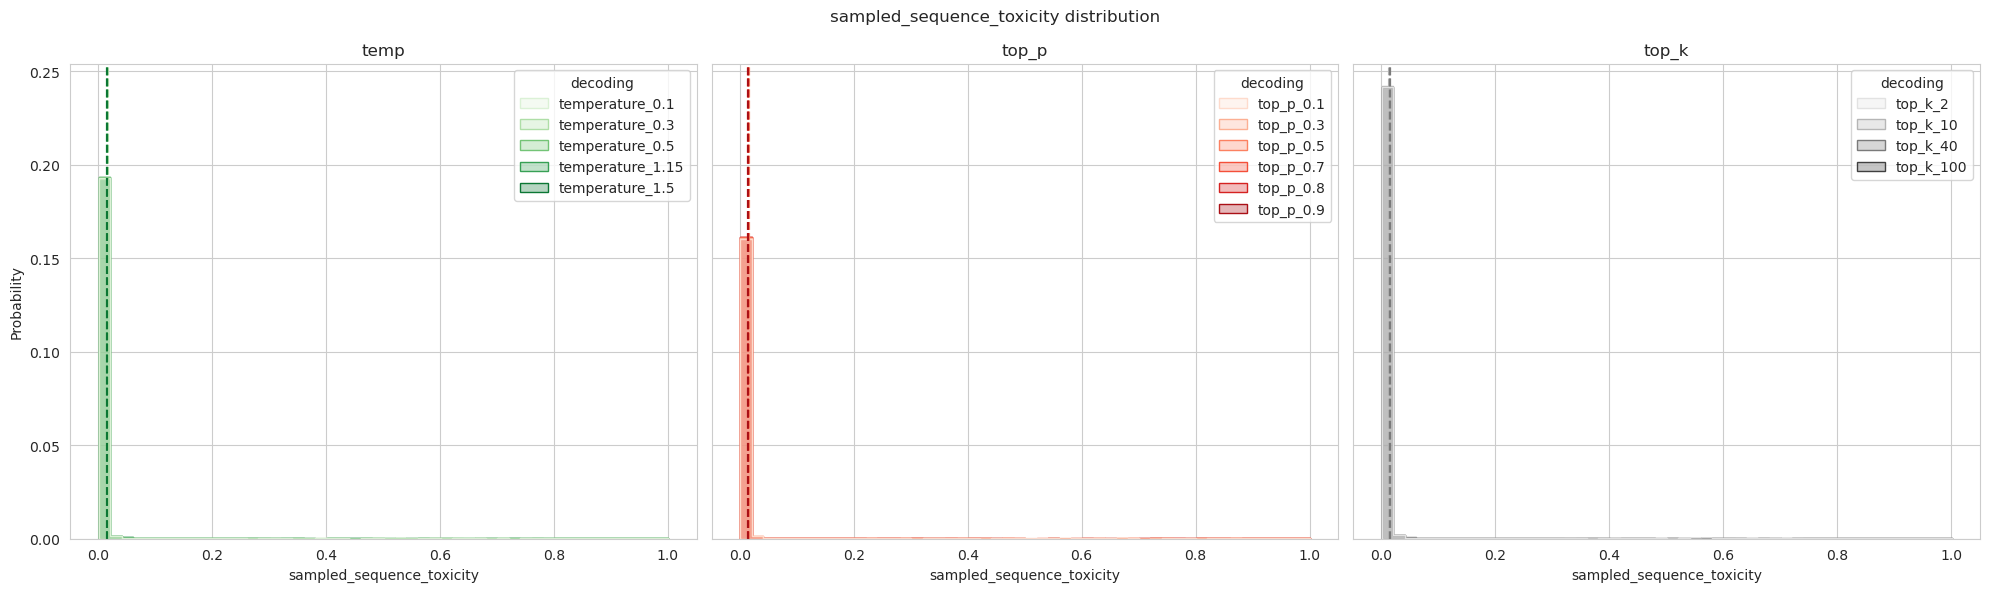

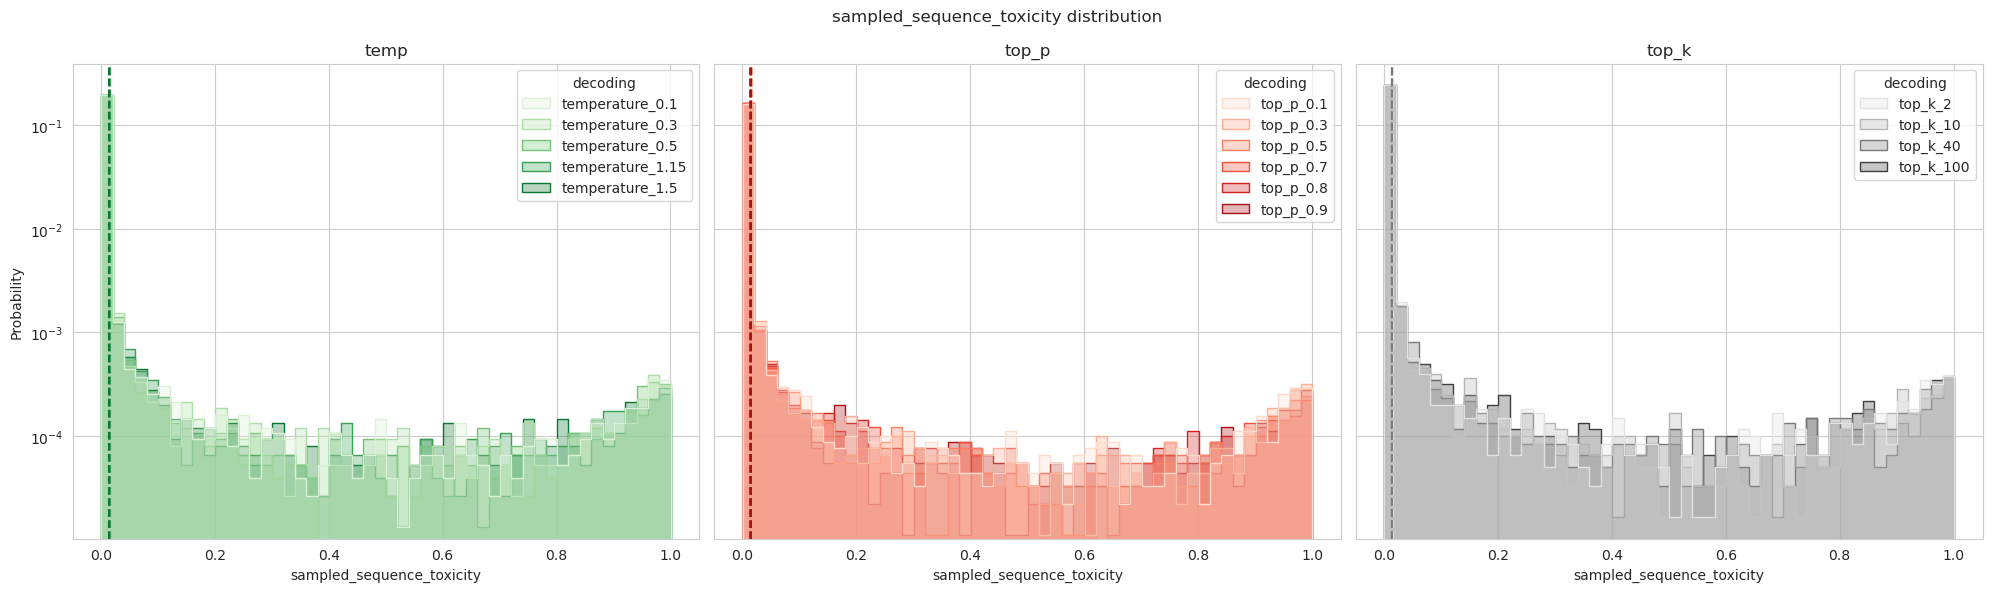

In [39]:
plot_histograms(property1="sampled_sequence_toxicity", binwidth=0.02)
plt.show()
plot_histograms(property1="sampled_sequence_toxicity", binwidth=0.02)
plt.yscale("log")
plt.show()

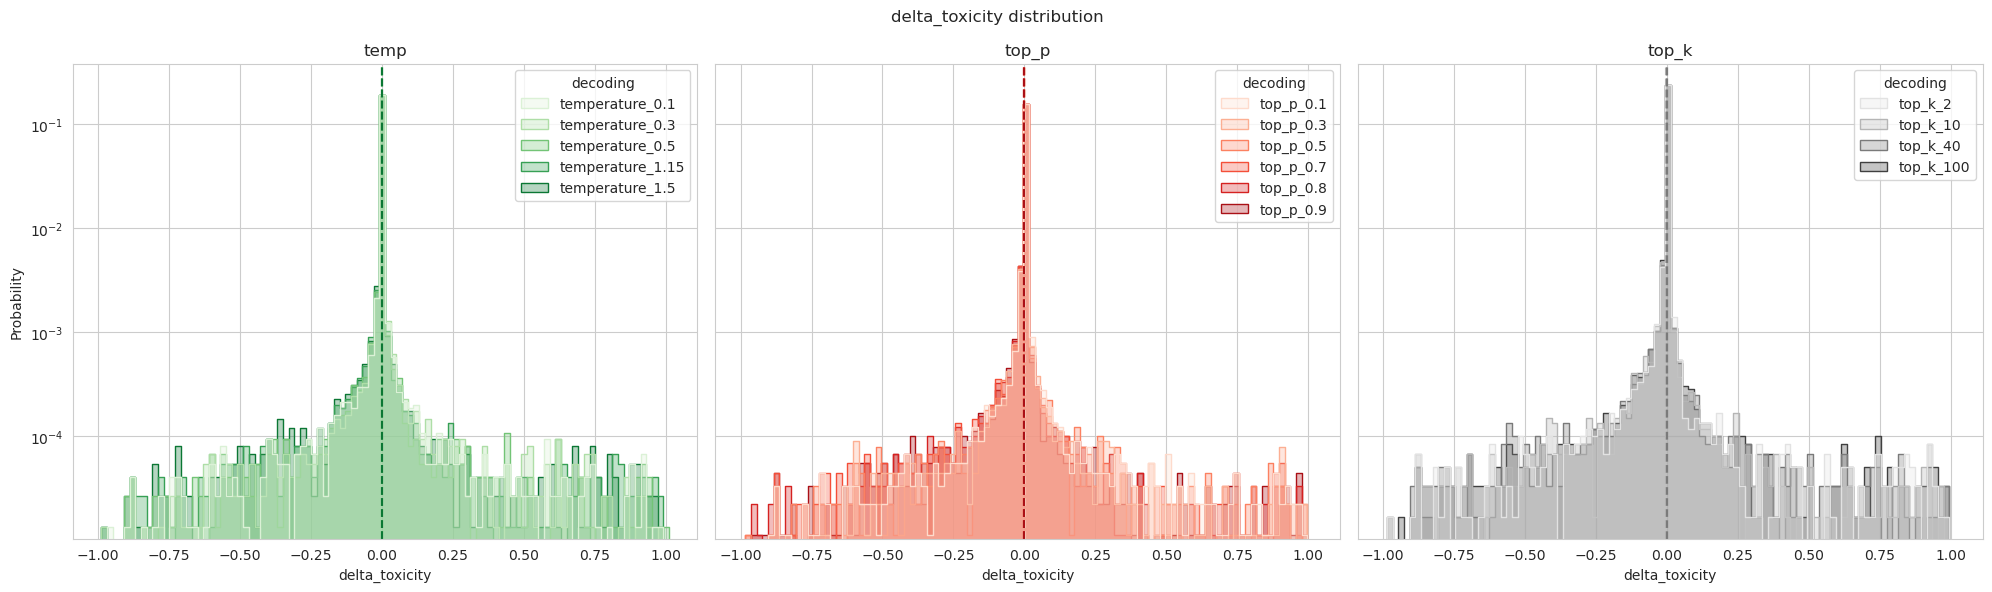

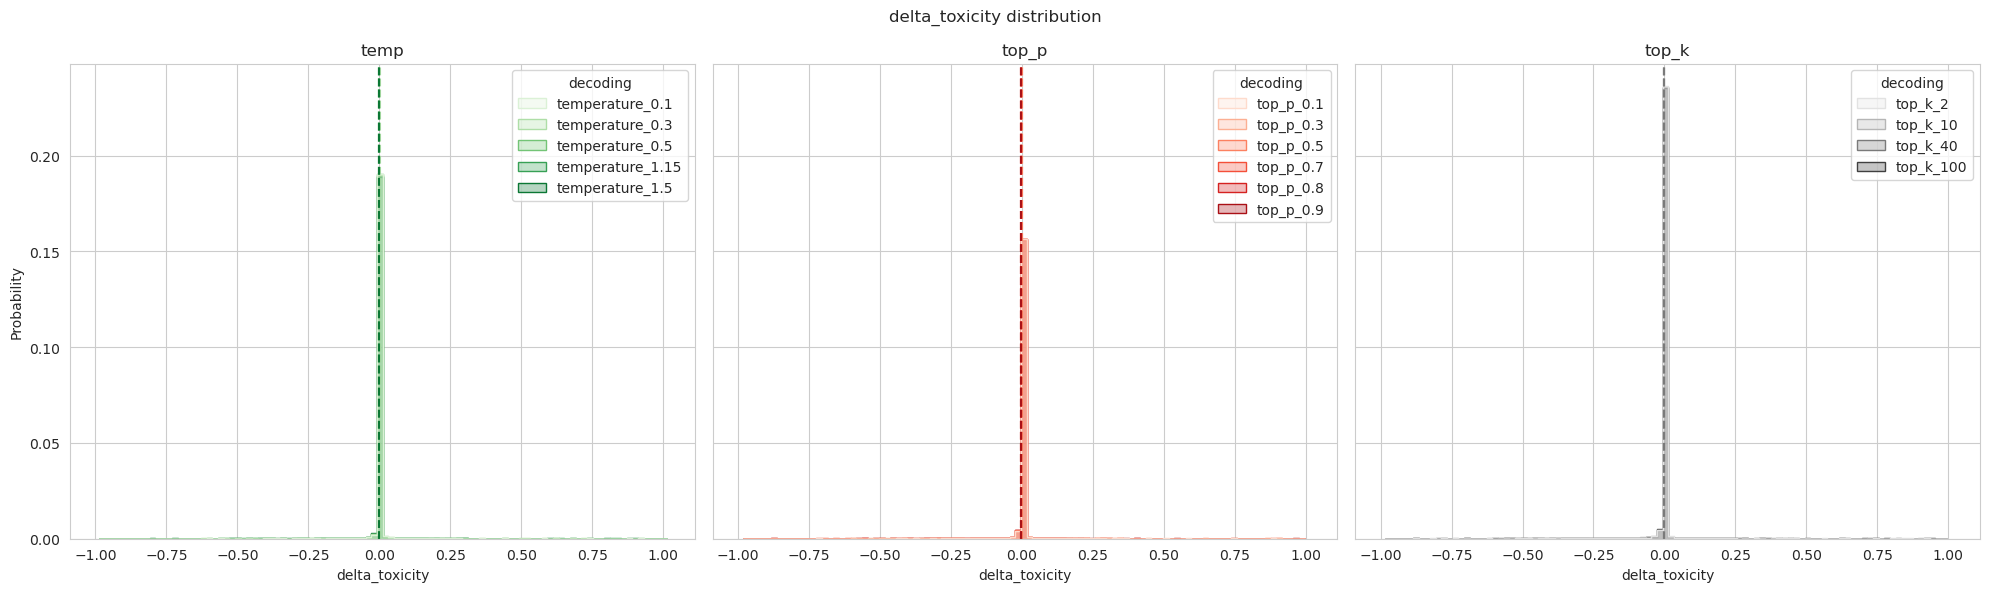

In [15]:
plot_histograms(property1="delta_toxicity", binwidth=0.02)
plt.yscale("log")
plt.show()
plot_histograms(property1="delta_toxicity", binwidth=0.02)
plt.show()

## Quantiles

In [16]:
import sys
sys.path.append("..")
from quantiles import quantile_intervals
from collections import defaultdict

import itertools as it

QUANTILES = [0.1, 0.5, 0.75, 0.9, 0.95, 0.99]
QUANTILES_CI_CONFIDENCE = 0.95

# Sanity check
r = quantile_intervals(len(files[0]), QUANTILES, desired_confidence=QUANTILES_CI_CONFIDENCE)
r

/home/cbelem/miniconda3/envs/py39/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'n': 15000,
 'desired_confidence': 0.95,
 'desired_quantiles': array([0.1 , 0.5 , 0.75, 0.9 , 0.95, 0.99]),
 'desired_ranks': array([ 1500.,  7500., 11250., 13500., 14250., 14850.]),
 'upper_interval_quantiles': array([0.10406667, 0.50673336, 0.7622667 , 0.90686667, 0.953     ,
        0.99233335], dtype=float32),
 'lower_interval_quantiles': array([0.09306667, 0.4876    , 0.74413335, 0.8958667 , 0.94553334,
        0.9886    ], dtype=float32),
 'upper_interval_ranks': array([ 1561,  7601, 11434, 13603, 14295, 14885]),
 'lower_interval_ranks': array([ 1396,  7314, 11162, 13438, 14183, 14829]),
 'interval_widths': array([0.95005001, 0.95006576, 0.95001116, 0.95005001, 0.9500032 ,
        0.95024798])}

In [20]:
def compute_quantiles(
        decodings,
        files,
        properties=["toxicity", "diversity", "num_sentences", "sequence_log_prob"],
        quantiles=QUANTILES,
        conf=QUANTILES_CI_CONFIDENCE,
    ):
    def add_base_info(r, algorithm, quants):
        r["decoding"].extend([algorithm] * len(quants))
        r["quantiles"].extend(quants.tolist())
    
    results = defaultdict(list)
    results_lo_rank = defaultdict(list)
    results_up_rank = defaultdict(list)
    
    print(len(decodings), len(files))
    # Iterate each decoding algorithm
    for dalgo, file in zip(decodings, files):
        print("Computing quantiles for", dalgo, "on", len(file), "examples")
        q_intervals = quantile_intervals(len(file), quantiles, conf)
        
        # Base information
        add_base_info(results, dalgo, q_intervals["desired_quantiles"])
        add_base_info(results_lo_rank, dalgo, q_intervals["desired_quantiles"])
        add_base_info(results_up_rank, dalgo, q_intervals["desired_quantiles"])

        # For each property, compute results, lower interval and upper_interval
        for prop1 in properties:
            val = file[prop1].sort_values().values
            
            # Measure rank
            q_ranks = q_intervals["desired_ranks"].astype(int)
            results[prop1].extend(val[q_ranks])
            
            # Intervals
            q_lranks = q_intervals["lower_interval_ranks"].astype(int)
            results_lo_rank[prop1].extend(val[q_lranks])
            
            q_uranks = q_intervals["upper_interval_ranks"].astype(int)
            results_up_rank[prop1].extend(val[q_uranks])
        
    return pd.DataFrame(results), pd.DataFrame(results_lo_rank), pd.DataFrame(results_up_rank)
    # return results, results_lo_rank, results_up_rank

print("Computing quantiles!")
properties = ['delta_toxicity', 'delta_num_punct', 'delta_diversity', 'delta_unique_words', 'delta_num_sentences']
quantiles_results, quantiles_lresults, quantiles_uresults = \
    compute_quantiles(decodings, files, properties=properties)
quantiles_results.head()

Computing quantiles!
16 16
Computing quantiles for multinomial on 15000 examples
Computing quantiles for temperature_0.1 on 15000 examples
Computing quantiles for temperature_0.3 on 15000 examples
Computing quantiles for temperature_0.5 on 15000 examples
Computing quantiles for temperature_1.15 on 15000 examples
Computing quantiles for temperature_1.5 on 15000 examples
Computing quantiles for top_k_2 on 15000 examples
Computing quantiles for top_k_10 on 15000 examples
Computing quantiles for top_k_40 on 15000 examples
Computing quantiles for top_k_100 on 15000 examples
Computing quantiles for top_p_0.1 on 15000 examples
Computing quantiles for top_p_0.3 on 15000 examples
Computing quantiles for top_p_0.5 on 15000 examples
Computing quantiles for top_p_0.7 on 15000 examples
Computing quantiles for top_p_0.8 on 15000 examples
Computing quantiles for top_p_0.9 on 15000 examples


,decoding,quantiles,delta_toxicity,delta_num_punct,delta_diversity,delta_unique_words,delta_num_sentences
0,multinomial,0.10,-0.000943,2,-0.196078,11,0
1,multinomial,0.50,-0.000024,6,-0.109128,23,1
2,multinomial,0.75,0.000102,8,-0.062436,27,2
3,multinomial,0.90,0.000370,12,-0.013464,30,3
4,multinomial,0.95,0.000958,15,0.006349,32,3


In [19]:
files[0].columns

Index(['sequence', 'prefix', 'continuation', 'sequence_num_tokens',
       'prefix_num_tokens', 'continuation_num_tokens', 'sampling_kwargs',
       'original_filepath', 'prefix_kwargs', 'sampled_sequence_num_chars',
       'sampled_sequence_num_sentences', 'sampled_sequence_num_punct',
       'sampled_sequence_num_words', 'sampled_sequence_unique_words',
       'sampled_sequence_diversity', 'sampled_sequence_toxicity',
       'sampled_sequence_severe_toxic', 'sampled_sequence_obscene',
       'sampled_sequence_threat', 'sampled_sequence_insult',
       'sampled_sequence_identity_hate', 'decoding', 'sampled_continuation',
       'sampled_sequence', 'delta_toxicity', 'delta_num_punct',
       'delta_diversity', 'delta_unique_words', 'delta_num_sentences'],
      dtype='object')

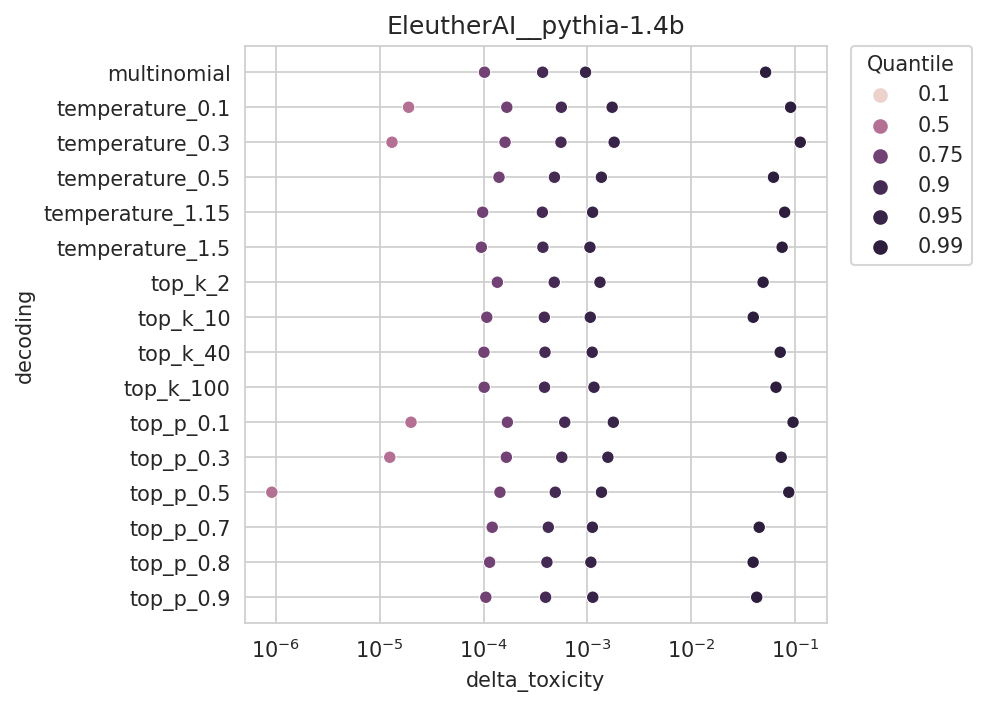

In [22]:
def plot_quantiles(quantiles_results, colname: str="toxicity"):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=150)
    sns.scatterplot(quantiles_results, y="decoding", x=colname, hue="quantiles", ax=ax)
    plt.legend(title="Quantile", bbox_to_anchor=(1.25, 1), borderaxespad=0)
    plt.title(MODEL)
    
plot_quantiles(quantiles_results, "delta_toxicity")
plt.xscale("log")
plt.show()

### Quantiles with error bars

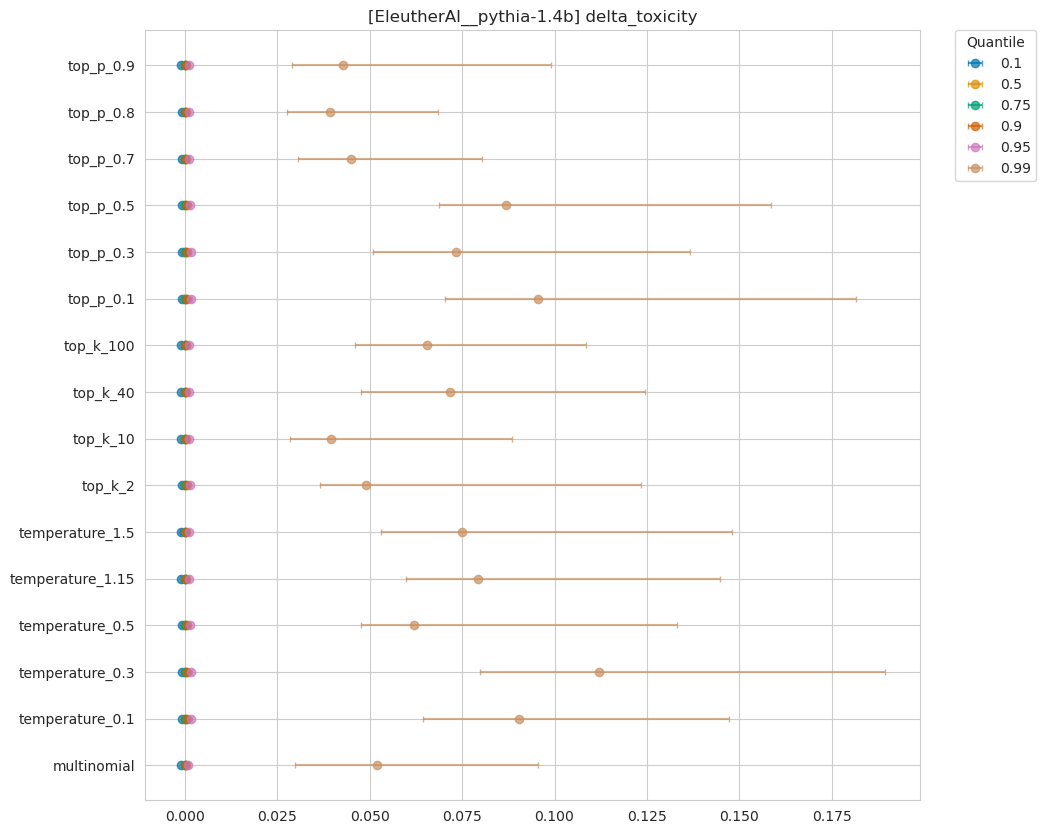

In [42]:
QUANTILE_PALETTE = sns.color_palette("colorblind", n_colors=len(QUANTILES))
QUANTILE_COLORS = {q: color for color, q in zip(QUANTILE_PALETTE, QUANTILES)}


def plot_quantiles_w_error_bars(quantiles, low_quantiles, up_quantiles, colname="toxicity", qs=QUANTILES, color_by_quantiles=QUANTILE_COLORS, figsize=(10, 10)):
    """Plot the quantiles and the error bars as given by low_quantiles and up_quantiles.
    
    Parameters
    ----------
    quantiles: pandas.DataFrame
        The data containing the values for different decoding algorithms
        and quantiles
    
    low_quantiles: pandas.DataFrame
        The absolute lower bound of the quantiles for different decoding
        algorithms,
        
    up_quantiles: pandas.DataFrame
        The absolute upper bound of the quantiles for different decoding
        algorithms. We convert it to relative automatically.
        
    qs: list[float]
        The list with the desired quantiles to map. Make sure you
        specify quantile values that are present in the data you
        provide and for which the color has been defined as well.
    """
    def get_quantile_subset(data, q):
        return data[data["quantiles"] == q].copy()

    fig, ax = plt.subplots(1, 1, figsize=figsize)
    errs = []
    # Iterate for each different value of quantile
    for q in qs:
        # Pick a common color
        qcolor = color_by_quantiles[q]
        # Select a slice of the data that is specific to that quantile
        qresults = get_quantile_subset(quantiles, q)
        # Select the same slice from the lower quantile
        qlresults = get_quantile_subset(low_quantiles, q)
        # Select the slice from the upper quantile
        quresults = get_quantile_subset(up_quantiles, q)
        # The size of these slices should be the same
        assert len(qresults) == len(qlresults) == len(quresults)
        
        # Generate some example data
        x = qresults[colname].values
        y = qresults["decoding"].values
        y_err = np.vstack((
            qresults[colname].values - qlresults[colname].values,
            quresults[colname].values - qresults[colname].values,
        ))
        # Create the scatterplot with error bars
        plt.errorbar(x, y, xerr=y_err, fmt='o', capsize=2, color=qcolor, label=q, alpha=0.7)
        errs.append(y_err)

    # Show the plot
    plt.title(f"[{MODEL}] {colname}")
    plt.legend(title="Quantile", bbox_to_anchor=(1.15, 1), borderaxespad=0)
    
    
plot_quantiles_w_error_bars(
    quantiles=quantiles_results,
    low_quantiles=quantiles_lresults,
    up_quantiles=quantiles_uresults,
    colname="delta_toxicity",
    qs=QUANTILES, 
)

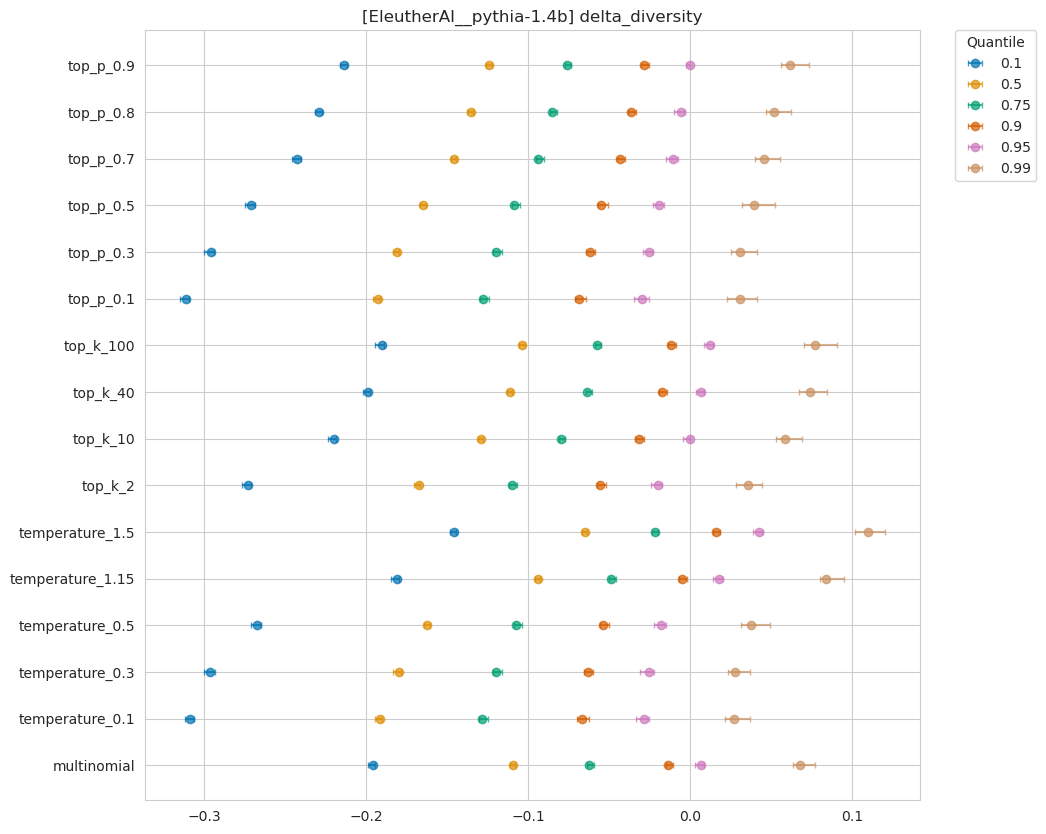

In [29]:
plot_quantiles_w_error_bars(
    quantiles=quantiles_results,
    low_quantiles=quantiles_lresults,
    up_quantiles=quantiles_uresults,
    colname="delta_diversity",
    qs=QUANTILES, 
)

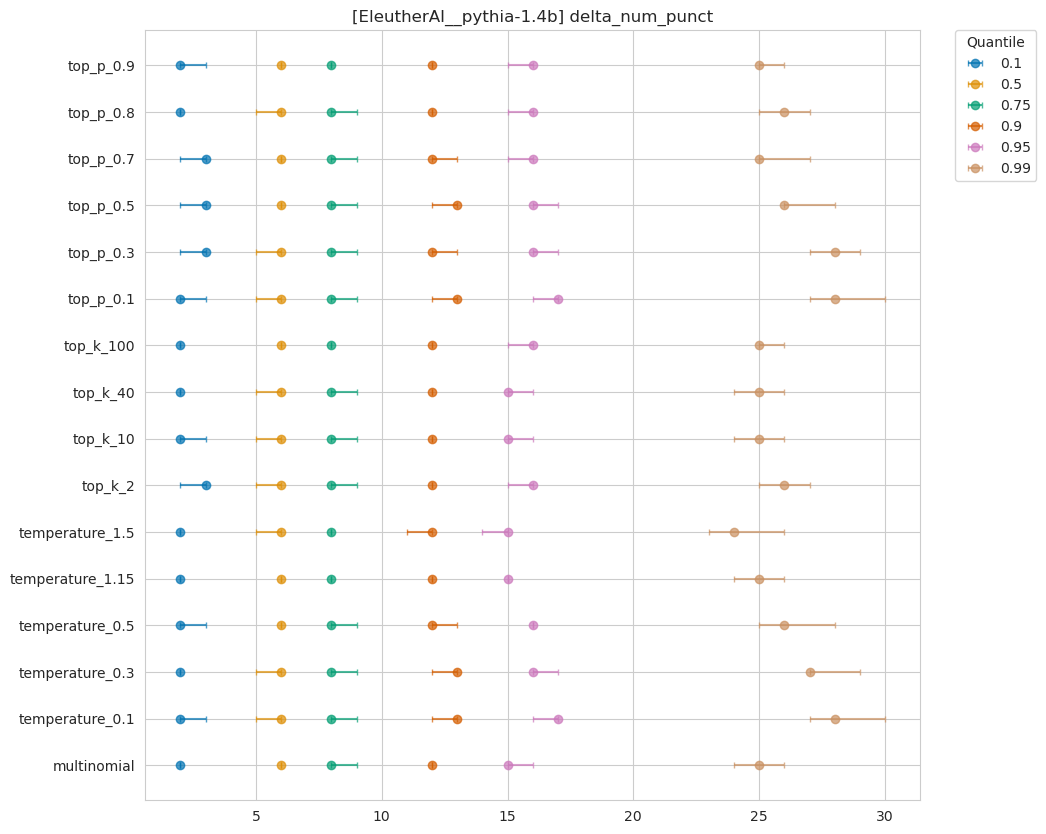

In [33]:
plot_quantiles_w_error_bars(
    quantiles=quantiles_results,
    low_quantiles=quantiles_lresults,
    up_quantiles=quantiles_uresults,
    colname="delta_num_punct",
    qs=QUANTILES, 
)

In [ ]:
sns.scatterplot(quantiles_results, x="quantiles", y="sequence_log_prob", hue="decoding", palette=ALL_COLORS)
sns.lineplot(quantiles_results, x="quantiles", y="sequence_log_prob", hue="decoding", palette=ALL_COLORS)

In [ ]:
plot_quantiles_w_error_bars(
    quantiles=quantiles_results,
    low_quantiles=quantiles_lresults,
    up_quantiles=quantiles_uresults,
    colname="toxicity",
    qs=QUANTILES, 
)

In [ ]:
plot_quantiles_w_error_bars(
    quantiles=quantiles_results,
    low_quantiles=quantiles_lresults,
    up_quantiles=quantiles_uresults,
    colname="diversity",
    qs=QUANTILES, 
)

In [ ]:
plot_quantiles_w_error_bars(
    quantiles=quantiles_results,
    low_quantiles=quantiles_lresults,
    up_quantiles=quantiles_uresults,
    colname="sequence_log_prob",
    qs=QUANTILES, 
)

## Joint distributions

In [ ]:
def plot_joints(decodings, files, x="toxicity", y="diversity", bins=(50, 50), rang=((0,1), (0,1))):
    for dalgo, file in zip(decodings, files):
        fig, ax = plt.subplots(1,1, figsize=(7, 5))
        plt.title(f"[{MODEL}: {dalgo}]")
        ax.hist2d(x=file[x], y=file[y], bins=(100, 20), cmap=plt.cm.Reds, density=True, range=rang)
        ax.set_xlabel(x)
        ax.set_ylabel(y)
        plt.show()

In [ ]:
plot_joints(decodings, files, "toxicity", "diversity", bins=(100, 50))

### Barplot

In [ ]:
barplot(all_files_concat[all_files_concat["toxicity"] > 0.5], "decoding", "toxicity")

## Greedy-like sequences

In [45]:
from rich.console import Console
from rich.text import Text

# Console for printing with nice colors :)
console = Console(width=80)

ALL_COLORS = {}
for colors_dict in DEFAULT_COLORS.values():
    for k, v in colors_dict.items():
        ALL_COLORS[k] = v
        
def pprint(text, model_score, decoding, counts=0):
    msg  = f"\n\n({decoding}) {model_score:.2%} Toxicity (generated {counts} times /15000)\nText: [cyan]'{text}'[/cyan]"
    console.print(msg)
    
    
def pprint_df(df: pd.DataFrame, colname: str, n=None):
    df_ndup = df.drop_duplicates("sequence").reset_index(drop=True).copy()

    for i, row in df_ndup.iterrows():
        n_times = (df["sequence"] == row["sequence"]).sum()
        pprint(row["sequence"], row[colname], row["decoding"], n_times)
        
        if n is not None and i > n:
            print(i, n)
            break

In [47]:
temp_greedy = files[decodings.index("temperature_0.1")].sort_values("toxicity", ascending=False)
print("Temperature=0.1: |S| =", temp_greedy['sequence'].nunique())

top_p_greedy  = files[decodings.index("top_p_0.1")].sort_values("toxicity", ascending=False)
print("Top-p=0.1: |S| =", top_p_greedy['sequence'].nunique())

top_k_greedy  = files[decodings.index("top_k_2")].sort_values("toxicity", ascending=False)
print("Top-k=2: |S| =", top_k_greedy['sequence'].nunique())

KeyError: 'toxicity'

In [ ]:
pprint_df(top_p_greedy, "toxicity", 1)

In [ ]:
pprint_df(temp_greedy, "toxicity", 50)

In [ ]:
pprint_df(top_k_greedy, "toxicity", 50)

# Worst case analysis

### Toxicity Analysis

In [ ]:
bottom_files = [f.sort_values("toxicity", ascending=False).head(150) for f in files]
bottom_files_concat = pd.concat(bottom_files, axis=0)
bottom_quantiles = compute_quantiles(decodings, bottom_files)

In [ ]:
plot_quantiles(bottom_quantiles, "toxicity")
plot_quantiles(bottom_quantiles, "diversity")

In [ ]:
plot_joints(decodings, bottom_files, "toxicity", "diversity", bins=(50, 50), rang=((0,1), (0,1)))